In [23]:
import h5py
import numpy as np
import numba
import matplotlib
from matplotlib.pyplot import figure, colorbar, savefig, title, xlabel, ylabel, imshow, close
import timeit
from numba import cuda
import llvmlite.binding as llvm
llvm.set_option('', '--debug-only=loop-vectorize')

In [46]:
@numba.jit(nopython=True, nogil=True, cache=True)
def onemove_in_cube_true_numba(p0, v):
    htime = np.abs((np.floor(p0) - p0 + (v > 0)) / v)  
    minLoc = np.argmin(htime) 
    dist = htime[minLoc] 
    htime = p0 + dist * v 
    htime[minLoc] = np.round(htime[minLoc]) + np.spacing(np.abs(htime[minLoc])) * np.sign(v[minLoc])
    return htime, dist

In [47]:
def main_loop(Nx, Ny, Nz, Mx, My, D, h, orginOffset, ep, mu):
    detector = np.zeros((Mx, My), dtype=np.float32) 
    for i in range(Mx): 
        for j in range(My):
            pos = np.array([orginOffset[0] + i * D, orginOffset[1] + D * j, 0], dtype=np.float32) 
            dir = ((ep - pos) / np.linalg.norm(ep - pos)).astype(np.float32)
            dir[dir == 0] = 1e-16
            L = 0  
            h_z = h + Nz
            while pos[2] < h_z:  
                pos, dist = onemove_in_cube_true_numba(pos, dir)  
                if 0 <= pos[0] < Nx and 0 <= pos[1] < Ny and h <= pos[2] < h_z:
                    L += mu[int(np.floor(pos[0])),int(np.floor(pos[1])) , int(np.floor(pos[2] - h))] * dist
            detector[i][j] = L 
    return detector

In [48]:
f = h5py.File('headct.h5', 'r') #HDF5 file containing Headct array of linear attenuation coeffcients(Nx,Ny,Nz)
headct=np.array(f.get('ct'))
headct=np.transpose(headct) #linear attenuation coeffceient matrix
det=f.get('det')
det=np.transpose(det) #Result of running this code on Matlab for later comparsion
Nx = np.size(headct,0) #Imaging x dimension length in mm
Ny = np.size(headct,1) #Imaging y dimension length in mm
Nz = np.size(headct,2) #Imaging z dimension length in mm
Mx = 200 #Number of pixels in x direction
My = 200 #Number of pixels in y direction
D = 2 #Size of each pixel in mm
h = 50 #distance(Z) bettween bottom of imaging volume and detector
H = h + Nz + 200 #distance(Z) bettween detector and x-ray source
muBone = 0.573 #linear attenuation coeffcient bone cm^-1
muFat = 0.193 #linear attenuation coeffcient fat cm^-1
orginOffset = np.array([(-Mx * D) / 2 + (Nx / 2), (-My * D) / 2 + (Ny / 2), 0], dtype=np.float32) #offset from origin to detector start (X,Y,Z)
ep = np.array([Nx / 2, Ny / 2, H], dtype = np.float32) #location of x-ray soruce
orginOffset = np.array([(-Mx * D) / 2 + (Nx / 2), (-My * D) / 2 +(Ny / 2), 0],dtype=np.float32) #offset from origin to detector start
mu=np.zeros((Nx,Ny,Nz),dtype=np.float32) #(Nx,Ny,Nz) linear attenuation coeffcient matrix 
mu[np.nonzero(headct>0)]=((headct[np.nonzero(headct>0)]-0.3)/(0.7))*(muBone-muFat)+muFat #Normilization of givens mus of linear attenuation matrix

In [49]:
main_loop_par=numba.njit(main_loop)

In [45]:
detA = main_loop_par(Nx, Ny, Nz, Mx, My, D, h, orginOffset, ep, mu)
detector = np.exp(detA * -10, dtype=np.float64)

[ 99. 123.   0.] [0.01052515 0.01052515 0.9998892 ]
[ 99.01053   123.01053     1.0000001] [0.01052515 0.01052515 0.9998892 ]
[ 99.02106   123.02106     2.0000002] [0.01052515 0.01052515 0.9998892 ]
[ 99.031586  123.031586    3.0000002] [0.01052515 0.01052515 0.9998892 ]
[ 99.042114  123.042114    4.0000005] [0.01052515 0.01052515 0.9998892 ]
[ 99.05264   123.05264     5.0000005] [0.01052515 0.01052515 0.9998892 ]
[ 99.06317   123.06317     6.0000005] [0.01052515 0.01052515 0.9998892 ]
[ 99.0737    123.0737      7.0000005] [0.01052515 0.01052515 0.9998892 ]
[ 99.08423  123.08423    8.000001] [0.01052515 0.01052515 0.9998892 ]
[ 99.09476  123.09476    9.000001] [0.01052515 0.01052515 0.9998892 ]
[ 99.105286 123.105286  10.000001] [0.01052515 0.01052515 0.9998892 ]
[ 99.115814 123.115814  11.000001] [0.01052515 0.01052515 0.9998892 ]
[ 99.12634  123.12634   12.000001] [0.01052515 0.01052515 0.9998892 ]
[ 99.13687  123.13687   13.000001] [0.01052515 0.01052515 0.9998892 ]
[ 99.1474   123.1

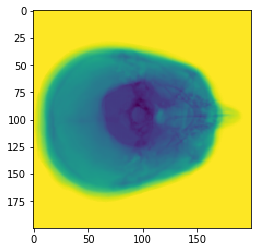

In [21]:
imshow(np.log(detector))

In [58]:
@cuda.jit(device=True)
def onemove_in_cube_true_numba(p0, v):
    htime=cuda.local.array((3,1), dtype=np.float32)
    for i in range(3):
        if v[i]>0:
            htime[i]=abs((math.floor(p0[i]) - p0[i] + (v[i] > 0)) / v[i])  
        else:
            htime[i]=abs((math.floor(p0[i]) - p0[i] + (v[i] > 0)) / v[i])  
    minA=0
    minV=htime[0]
    for i in range(1,3):
        if minV>htime[i]:
            minA=i
            minV=htime[i]
    dist = htime[minA] 
    for i in range(3):
        htime[i] = p0[i] + dist * v[i] 
    if v[minA]<0:
        htime[minLoc] = round(htime[minLoc]) + 1.5e-19 * -1
    else:
        htime[minLoc] = round(htime[minLoc]) + 1.5e-19 
    return htime, dist

In [59]:
@cuda.jit
def main_loop(obj_dim, scene_info, orginOffset, ep, mu, detector):
    i, j = cuda.grid(2)
    if i < detector.shape[0] and j <detector.shape[1]:
        pos=cuda.local.array((3,1), dtype=np.float32)
        direction=cuda.local.array((3,1), dtype=np.float32)
        pos[0]=orginOffset[0] + i * scene_info[0]
        pos[1]=orginOffset[1] + scene_info[0] * j
        pos[2]=0
        norm=0
        
        for k in range(3):
            norm+=math.pow(ep[k]-pos[k],2)  
        norm=math.sqrt(norm)
        
        for k in range(3):
            direction[k]=(ep[k]-pos[k])/norm
            if direction[k]==0:
                direction[k]=1e-16        
        L = 0  
        h_z = scene_info[1] + obj_dim[1]
        while pos[2] < h_z:  
            pos, dist = onemove_in_cube_true_numba(pos, dir)  
            if 0 <= pos[0] < obj_dim[0] and 0 <= pos[1] < obj_dim[1] and  scene_info[1] <= pos[2] < h_z:
                L += mu[math.floor(pos[0]),math.floor(pos[1]) , math.floor(pos[2] -  scene_info[1])] * dist
        detector[i][j] = L 
    return detector

In [61]:
stream = cuda.stream()
h_detector = np.zeros((Mx, My), dtype=np.float32) 
d_detector = cuda.to_device(h_detector, stream)
d_mu=cuda.const.array_like(mu)
h_obj_dim=np.array([Nx,Ny, Nz])
d_obj_dim = cuda.to_device(h_obj_dim, stream)
h_scene_info=np.array([D, h])
d_scene_info = cuda.to_device(h_scene_info, stream)
d_ep = cuda.to_device(orginOffset, stream)
d_orginOffset = cuda.to_device(ep, stream)
main_loop[1024, 1024, stream](d_obj_dim, d_scene_info, d_orginOffset, d_ep, d_mu, d_detector)
detector = d_detector.copy_to_host(stream=stream)



CudaSupportError: Error at driver init: 
[3] Call to cuInit results in CUDA_ERROR_NOT_INITIALIZED: